# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [45]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
print(len(data))
data

3975


,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
5,Drake,"Ayy, yeah I got one, Laurie got one and that t..."
6,Drake,"Well, summer, all I did was rest, okay? And Ne..."
7,Drake,I'm makin' a change today The liquor been taki...
8,Drake,(Six) Yeah Yeah Yeah
9,Drake,"Leave me out the comments, leave me out the no..."


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [46]:
# YOUR CODE HERE
data['verse'].iloc[18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [47]:
import unidecode
data['verse']= data['verse'].apply(unidecode.unidecode)

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [48]:
# YOUR CODE HERE
data = data.drop_duplicates()

In [49]:
len(data)

3031

In [50]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [51]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [52]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [53]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [54]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [55]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [56]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [57]:
# YOUR CODE HERE
def word_to_text(txt):
    return tf.keras.preprocessing.text.text_to_word_sequence(
    txt,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' '
)


In [58]:
data['seq'] = data['verse'].apply(word_to_text)

c:\users\adric\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
data['len'] = data['seq'].apply(len)

c:\users\adric\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

<AxesSubplot:xlabel='Density', ylabel='len'>

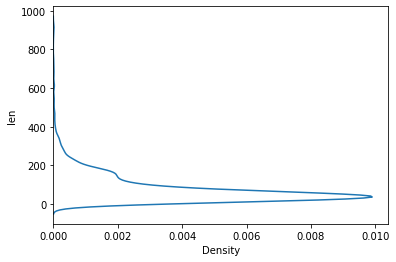

In [60]:
# YOUR CODE HERE
#sns.displot(data=data, kind="kde")
sns.kdeplot(data=data, y='len')

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [61]:
# YOUR CODE HERE
def slice_if_too_much(array):
    if len(array) > 300:
        return array[0:300]
    else:
        return array
    
data['seq'] = data['seq'].apply(slice_if_too_much)

c:\users\adric\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<AxesSubplot:xlabel='Density', ylabel='len'>

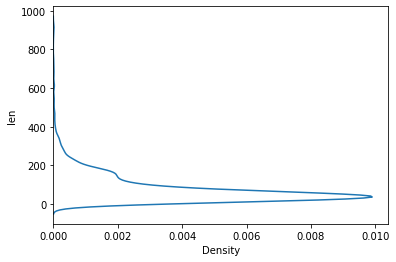

In [62]:
sns.kdeplot(data=data, y='len')

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [116]:
# YOUR CODE HERE
from gensim.models import Word2Vec
X_train = data['seq']
word2vec = Word2Vec(sentences=X_train, size=100)
# This line trains an entire embedding for the words in your train set

def embed_sentence(word2vec, sentence):
    ### YOUR CODE HERE
    matrix=[]
    for i in sentence:
        if i in word2vec.wv:
            matrix.append(word2vec.wv[i])
        
    mat = np.array(matrix)
    return mat
data['embed'] = data.apply(lambda x: embed_sentence(word2vec ,x['seq']), axis=1)

c:\users\adric\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [91]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [92]:
# YOUR CODE HERE
data

,artist,verse,seq,len,embed,y
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]",5,"[[0.61315316, -0.2512606, -0.41122273, -0.4377...",0
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",60,"[[0.046711273, -0.34679475, -0.30884027, -0.21...",0
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...",96,"[[-0.17784311, -0.31470653, -0.08981248, -0.51...",0
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...",65,"[[0.05837266, -0.3444783, -0.18644601, -0.3630...",0
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",61,"[[0.046711273, -0.34679475, -0.30884027, -0.21...",0
5,Drake,"Ayy, yeah I got one, Laurie got one and that t...","[ayy, yeah, i, got, one, laurie, got, one, and...",155,"[[0.61315316, -0.2512606, -0.41122273, -0.4377...",0
8,Drake,(Six) Yeah Yeah Yeah,"[six, yeah, yeah, yeah]",4,"[[0.1716511, -0.08094976, -0.0502419, -0.22779...",0
9,Drake,"Leave me out the comments, leave me out the no...","[leave, me, out, the, comments, leave, me, out...",173,"[[0.11528596, -0.26525274, -0.14333628, -0.429...",0
10,Drake,"Sins, I got sins on my mind And some M's, got ...","[sins, i, got, sins, on, my, mind, and, some, ...",85,"[[0.017710447, 0.0010772574, -0.0026246123, -0...",0
11,Drake,"I'm from the four, but I love me a threesome D...","[i'm, from, the, four, but, i, love, me, a, th...",270,"[[0.046711273, -0.34679475, -0.30884027, -0.21...",0


❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [117]:
# YOUR CODE HERE
def label_artist(artist):
    if artist == 'Drake':
        return 0
    elif artist == 'Ed Sheeran':
        return 1
    else:
        return 2
data['y'] = data['artist'].apply(label_artist)

c:\users\adric\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [134]:
def if_shorter(array):
    length = len(array)
    if length < 300:
        for i in range((300-length)):
            array = np.append(array,[0])
            
        return array

In [135]:
data['embed'] = data['embed'].apply(if_shorter)

c:\users\adric\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [136]:
X = data['embed']
y = data['y']
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [144]:
len(X[0])

795

👉 We train/test split the dataset below for you

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [139]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [198]:
score_baseline = 1391/3031

In [183]:

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
#! rm data_lyrics_solution.pickle

In [187]:
print(X_train.shape)
print(y_train.shape)


(2424, 300, 100)
(2424, 3)


In [184]:
print(y_train[0].shape)

(3,)


In [203]:
from tensorflow.keras import layers, Sequential
from keras.layers import Embedding,LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
embedding_size = 100

model = Sequential()
model.add(layers.Embedding(
    input_dim=(X_train.shape[0]), 
    input_length=300, 
    output_dim=embedding_size,# 100
    mask_zero=True
    
))
model.add(layers.LSTM(20),return_sequences=True)
model.add(layers.Dense(3, activation="softmax"))
model.summary()

TypeError: add() got an unexpected keyword argument 'return_sequences'

In [200]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5


ValueError: in user code:

    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer lstm_23 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 300, 100, 100]


In [156]:
# YOUR CODE HERE
from tensorflow.keras import layers, Sequential
from keras.layers import Embedding,LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Embedding(300, 100, input_length=2424))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5


ValueError: in user code:

    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer lstm_2 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 300, 100, 100]


Epoch 1/5


InvalidArgumentError:  Incompatible shapes: [64,300,3] vs. [64,3]
	 [[node gradient_tape/mean_squared_error/BroadcastGradientArgs (defined at <ipython-input-197-bb863115d447>:19) ]] [Op:__inference_train_function_15465]

Function call stack:
train_function


❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [211]:
# YOUR CODE HERE
embedding_size = 100
model_rnn = Sequential()
model_rnn.add(layers.Embedding(
    input_dim=2424, # vocab_size
    input_length=300, # sentences_lengths
    output_dim=, # embedding_size
    mask_zero=True))
model_rnn.add(layers.LSTM(10))
model_rnn.add(layers.Dense(3, activation="softmax"))

TypeError: __init__() missing 1 required positional argument: 'output_dim'

In [206]:
model_rnn.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 100)          242400    
_________________________________________________________________
lstm_26 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 33        
Total params: 246,873
Trainable params: 246,873
Non-trainable params: 0
_________________________________________________________________


In [209]:
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [210]:
# YOUR CODE HERE

epochs = 5
batch_size = 64
history = model_rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5


ValueError: in user code:

    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\adric\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer lstm_26 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 300, 100, 100]


❓ **Plot the training and validation losses through training**

In [37]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [40]:
# YOUR CODE HERE

🧪 **Send your results below**

In [33]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()